In [2]:
import astropy
import pandas as pd
from astropy.table import Table
from astropy.io import fits
import os
import numpy as np

from backend.cameraDataHandle import save_fits_data


### Example of importing the data from a known good fits file
The code below shows how to import the data into a header data unit (idk l) and then parse out the header information. Recall that the header is suppose to be used for recalling information later on about what was done during the experiment. 

In [21]:
hdul = fits.open('../example.fits')
hdul2 = fits.open("../Data/FITS_Data/datatest.fits")
hdul3 = fits.open("../TIC20212631_Real_g_20250316_123256.fits")

hdr = hdul[0].header
hdr2 = hdul2[0].header
hdr3 = hdul3[0].header

Below is how we could print out the key and value pair of the header file itself. This is the information that should be populated when we take out pictures witht he camera. We will know ahead of time what the conditions will be like, and other information about the experiment. Therefore we will be able to automatically populate the header file with useful information. 

In [22]:
for key, value in hdr3.items():
    print(f'{key}: {value}')
print('---')


SIMPLE: True
BITPIX: 16
NAXIS: 2
NAXIS1: 1024
NAXIS2: 1024
BSCALE: 1.0
BZERO: 32768.0
DATE-OBS: 2025-03-16T12:32:56.859
EXPTIME: 35.0
EXPOSURE: 35.0
SET-TEMP: -25.0
CCD-TEMP: -24.85996425
XPIXSZ: 13.0
YPIXSZ: 13.0
XBINNING: 1
YBINNING: 1
XORGSUBF: 0
YORGSUBF: 0
READOUTM: Monochrome
FILTER: g
IMAGETYP: LIGHT
FOCALLEN: 4014.0
APTDIA: 508.0
APTAREA: 195211.29477845234
SWCREATE: MaxIm DL Version 6.50 250810 1AJSF
SWSERIAL: 1AJSF-V5KK5-K3H21-UU9WW-71R38-V6
FOCUSPOS: 5639
FOCUSSSZ: 6.201171874993303
FOCUSTEM: 0.0
OBJCTRA: 15 08 09.14
OBJCTDEC: +39 58 12.9
OBJCTALT: 65.1371
OBJCTAZ: 295.3149
OBJCTHA: 01 58 55.54
SITELAT: 32 46 49
SITELONG: -105 49 13
JD: 2460751.022880324
JD-HELIO: 2460751.0259654955
AIRMASS: 1.10116937677
OBJECT: TIC20212631_Real
TELESCOP: ARCSAT 0.5-m
INSTRUME: dcam-spare
OBSERVER: AS04
NOTES: 
ROWORDER: TOP-DOWN
FLIPSTAT: Flip/Rotate 90 CW
CSTRETCH: Medium
CBLACK: 3369
CWHITE: 3752
PEDESTAL: 0
SWOWNER: William Ketzeback
JD-OBS: 2460751.0228803
HJD-OBS: 2460751.0257647
BJD-

## Working test code

The code block below works for connecting to the camera, setting the exposure rate to 40 ms, and then capturing 1 image at that rate. This is then shown as a heat map.



C:\Users\ellio\Desktop\Matthew\Speckle-Imaging-Camera-Control\venv\Lib\site-packages\pylablib\core\utils\module.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


[TAmpModeFull(channel=0, channel_bitdepth=16, oamp=0, oamp_kind='Electron Multiplying', hsspeed=0, hsspeed_MHz=30.0, preamp=0, preamp_gain=1.0),
 TAmpModeFull(channel=0, channel_bitdepth=16, oamp=0, oamp_kind='Electron Multiplying', hsspeed=0, hsspeed_MHz=30.0, preamp=1, preamp_gain=2.0),
 TAmpModeFull(channel=0, channel_bitdepth=16, oamp=0, oamp_kind='Electron Multiplying', hsspeed=1, hsspeed_MHz=20.0, preamp=0, preamp_gain=1.0),
 TAmpModeFull(channel=0, channel_bitdepth=16, oamp=0, oamp_kind='Electron Multiplying', hsspeed=1, hsspeed_MHz=20.0, preamp=1, preamp_gain=2.0),
 TAmpModeFull(channel=0, channel_bitdepth=16, oamp=0, oamp_kind='Electron Multiplying', hsspeed=2, hsspeed_MHz=10.0, preamp=0, preamp_gain=1.0),
 TAmpModeFull(channel=0, channel_bitdepth=16, oamp=0, oamp_kind='Electron Multiplying', hsspeed=2, hsspeed_MHz=10.0, preamp=1, preamp_gain=2.0),
 TAmpModeFull(channel=0, channel_bitdepth=16, oamp=0, oamp_kind='Electron Multiplying', hsspeed=3, hsspeed_MHz=1.0, preamp=0, prea

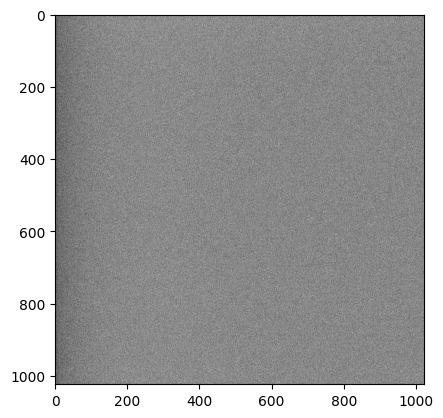

In [1]:
from pylablib.devices import Andor
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint


cam = Andor.AndorSDK2Camera(idx=0)#, temperature=None, fan_mode='full', amp_mode=None)
cam.open()
try:
    cam.set_fan_mode('full')

    cam.set_exposure(0.04)

    pprint(cam.get_all_amp_modes())


    pprint(cam.get_all_vsspeeds())
    cam.set_amp_mode(
        channel = 0,
        oamp    =  0,
        hsspeed = 1,
        preamp  = 1
    )

    cam.set_vsspeed(vsspeed=3)

    cam.setup_shutter(mode = "open")


    img = cam.grab(1)
    cam.close()
    plt.imshow(img[0], cmap='gray')
except Exception as e:
    print(f"Error: {e}")
    cam.close()




### Testing kinetic series

Now we need to test the kinetic series acquisiton mode on the cameras. We will test the procedure of configuration, the method for running the acquistion, and then the saving of the data

In [9]:
from pylablib.devices import Andor
from backend import cameraDataHandle
from backend.cameraConfig import Camera, CameraState
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import os
'''
num_cycle = 10
cycle_time = 11.60062
num_accum = 1
cycle_time_acc = 1.160063
'''
configuration_dir = r"C:\Users\ellio\Desktop\Matthew\Speckle-Imaging-Camera-Control\configs"
cam = Camera(0, -25, 'full', None)
info = cam.get_device_info()
cam.serialNumber = str(info[2])
cam.head_model = info[1]
cam.controller_mode = info[0]

num_of_images = 10
try:
    cam.camera_configuration(configDict=None, configDir = configuration_dir)

    cam.setup_kinetic_mode(
        num_cycle=10,
        cycle_time=0.02,
        num_acc=1,
        cycle_time_acc=0.004,
        num_prescan=0
    )
    cam.start_acquisition()  # start acquisition (automatically sets it up as well)
    frames = []
    for i in range(0, num_of_images, 1):
        cam.wait_for_frame()
        frame = cam.read_oldest_image()
        frames.append(frame)

    data = np.array(frames)
    print(data.shape)

    save_path = r"C:\Users\ellio\Desktop\Matthew\Speckle-Imaging-Camera-Control\Data\testing_kinetic_series"

    cameraDataHandle.save_fits_data(data, savepath=save_path, header_text=None, serial=cam.serialNumber)


    cam.disconnect()
except Exception as e:
    print(f"Error: {e}")
    cam.close()



Error: 
